# Policy Gradient Reinforcement Learning Algorithms

Methods that learn a parameterised policy instead of action-value functions. Learning is done through gradient ascent by maximising some performance measure J(theta).

Use the policy gradient theorem to separate the effect of the policy on the actions and rewards from the unknown effect of policy changes on the state distribution (induced by the environment dynamics, which is unknown). This theorem gives a formula for grad J(theta) which is proportional to a term that does not involve the derivative of the state distribution:

grad J(theta) i.p.t. sigma mew(s) sigma q(s,a) grad pi(a|s,theta)


### Discrete action space policies:
<br>
Use parameterised numerical preferences h(s,a,theta) for each state-action pair and softmax to select actions:
<br>
pi(a|s,theta) = exp(h(s,a,theta)) / sigma_b exp(e(s,b,theta))
<br>
(Note that b is used to sum over all actions.)
<br><br>
The simplest case is when h is a linear function:
<br>
h(s,a,theta) = theta^T x(s,a)
<br>
where x(s,a) is a feature vector.

### REINFORCE: Frozen Lake with softmax linear action preferences
Gradient Ascent update: <br>
Include 1 / pi(a|St, theta) to sample under the expectaion of all possible action values

grad J(theta) = Expectaion_pi [ Gt grad pi(At, St, theta) / pi(At, St, theta) ]
<br><br>
gives the gradient ascent update:
<br>
theta_t+1 = theta_t + alpha Gt grad pi(At, St, theta) / pi(At, St, theta)
<br><br>
... but use the "eligibilty vector" (from the identity grad ln x = grad x / x) and include gamma for discounting:
<br>
theta_t+1 = theta_t + alpha gamma^t Gt grad ln pi(At|St, theta)

episode 0 avg_returns 0
episode 100 avg_returns 0.0
episode 200 avg_returns 0.0
episode 300 avg_returns 0.0
episode 400 avg_returns 0.0
episode 500 avg_returns 0.0
episode 600 avg_returns 0.0
episode 700 avg_returns 0.0
episode 800 avg_returns 0.0
episode 900 avg_returns 0.0


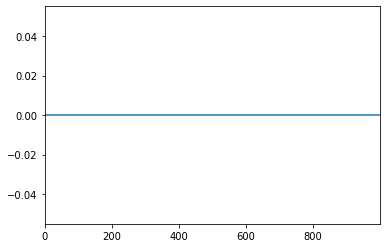

In [0]:
import gym
import time, random, math
import numpy as np
import pandas as pd
from IPython import display
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.special import softmax
%matplotlib inline
env = gym.make('FrozenLake8x8-v0', is_slippery=False)

#theta = np.zeros((30,env.action_space.n))
#q_values = np.zeros((env.observation_space.n, env.action_space.n))
#alpha_max, alpha_min, gamma, epsilon_max, epsilon_min = 1.0, 0.1, 0.99, 0.9, 0.1
gamma = 0.99
n_episodes = 1000
returns = []
avg_returns = [0]
avg_freq = 100

class ANN(nn.Module):
    def __init__(self, state_dims=env.observation_space.n, hs=128):
        super(ANN, self).__init__()        
        self.fc1 = nn.Linear(state_dims, hs)
        #self.fc2 = nn.Linear(hs, hs)
        self.out = nn.Linear(hs, env.action_space.n) # given a state, outputs an action preference for each action

    def forward(self, x):
        x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        return self.out(x)

theta = ANN()
optimiser = torch.optim.Adam(theta.parameters(), lr=0.001)#, weight_decay=0.001)

def features(state):
    oh = np.zeros(env.observation_space.n)
    oh[state] = 1
    return torch.Tensor(oh)

for n in range(n_episodes):
    env.reset()
    state,g = 0,0
    prefs = []
    rewards = []      
    if n%avg_freq==0:
        print('episode', n, 'avg_returns', avg_returns[-1])
    while True: # generate an episode
        # select an action according to policy pi
        #with torch.no_grad():
        action_preferences = theta(features(state))
        #action = np.random.choice(env.action_space.n, p=softmax(action_preferences)) # probabilistic action selection
        action = torch.argmax(action_preferences).item()        
        observation, reward, done, _ = env.step(action)
        prefs.append(action_preferences)
        rewards.append(reward)
        g += reward
        if done:             
            # learn pi    
            grads = []
            for t, p in enumerate(prefs):
                gt, pw = 0,0
                for r in rewards[t:]:
                    gt += gamma**pw * r
                    pw += 1
                grads.append(-torch.log(p)*gt)
            optimiser.zero_grad()
            J = torch.stack(grads).sum()
            J.backward()
            optimiser.step()
            # diagnostic
            returns.append(g)
            if n%avg_freq==(avg_freq-1):
                avg_returns.append(np.mean(returns[-avg_freq:]))    
            break
        state = observation                

pd.Series(returns).plot()

episode 0 avg_returns 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


episode 100 avg_returns 19.79
episode 200 avg_returns 18.55
episode 300 avg_returns 17.01
episode 400 avg_returns 14.71
episode 500 avg_returns 9.7
episode 600 avg_returns 9.95
episode 700 avg_returns 9.79
episode 800 avg_returns 9.47
episode 900 avg_returns 9.62
episode 1000 avg_returns 9.97
episode 1100 avg_returns 10.52
episode 1200 avg_returns 10.74
episode 1300 avg_returns 15.77
episode 1400 avg_returns 14.5
episode 1500 avg_returns 15.0
episode 1600 avg_returns 13.43
episode 1700 avg_returns 14.72
episode 1800 avg_returns 21.73
episode 1900 avg_returns 14.59


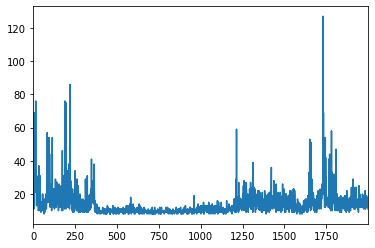

In [5]:
import gym
import time, random, math
import numpy as np
import pandas as pd
from IPython import display
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
#from scipy.special import softmax

env = gym.make('CartPole-v1')

gamma = 0.99
n_episodes = 2000
returns = []
avg_returns = [0]
avg_freq = 100

class ANN(nn.Module):
    def __init__(self, state_dims=env.observation_space.shape[0], hs=512):
        super(ANN, self).__init__()        
        self.fc1 = nn.Linear(state_dims, hs)
        self.fc2 = nn.Linear(hs, hs)
        self.out = nn.Linear(hs, env.action_space.n) # given a state, outputs an action preference for each action

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        #return F.softmax(self.out(x))
        return self.out(x)

theta = ANN()
optimiser = torch.optim.Adam(theta.parameters(), lr=0.001)#, weight_decay=0.001)

def features(state):    
    return torch.Tensor(state)

for n in range(n_episodes):
    state = env.reset()
    g = 0
    prefs = []
    rewards = []      
    if n%avg_freq==0:
        print('episode', n, 'avg_returns', avg_returns[-1])
    while True: # generate an episode
        # select an action according to policy pi
        #with torch.no_grad():
        action_preferences = theta(features(state))
        action = np.random.choice(env.action_space.n, p=F.softmax(action_preferences.detach()).numpy()) # probabilistic action selection
        #action = torch.argmax(action_preferences).item()        
        observation, reward, done, _ = env.step(action)
        prefs.append(action_preferences)
        rewards.append(reward)
        g += reward
        if done:             
            # learn pi    
            grads = []
            for t, p in enumerate(prefs):
                gt, pw = 0,0
                for r in rewards[t:]:
                    gt += gamma**pw * r
                    pw += 1
                grads.append(gt*torch.log(p))
            optimiser.zero_grad()
            J = torch.stack(grads).sum()
            J.backward()
            optimiser.step() # no loss function..!
            # diagnostic
            returns.append(g)
            if n%avg_freq==(avg_freq-1):
                avg_returns.append(np.mean(returns[-avg_freq:]))    
            break
        state = observation                

pd.Series(returns).plot()